# Load data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv(r'Y:\Data\2024_Vogt_LID_SWRDisruption\Results\ALLTRIAL_RFID.csv')  # Adjust the path to your alltrial RFID file

data.head()


,Unnamed: 0,trial,genotype,sex,name,code,trial_start,reader.id,antenna.id,read_tag,field_time,day,time_sec,noon_day,noon_time_sec,zone,zone_x,zone_y,alt_x,alt_y
0,1,T001,OBWT,M,Felldoh,MFEL,2024-06-22,2,4,985.113008,2024-06-22 19:05:11.299,1,68711.30,1,25511.30,4,4.12,15.24,1,2
1,2,T001,OBWT,M,Felldoh,MFEL,2024-06-22,2,4,985.113008,2024-06-22 19:05:12.440,1,68712.44,1,25512.44,4,4.12,15.24,1,2
2,3,T001,OBWT,M,Felldoh,MFEL,2024-06-22,2,4,985.113008,2024-06-22 19:06:20.599,1,68780.60,1,25580.60,4,4.12,15.24,1,2
3,4,T001,OBWT,M,Felldoh,MFEL,2024-06-22,2,4,985.113008,2024-06-22 19:07:26.140,1,68846.14,1,25646.14,4,4.12,15.24,1,2
4,5,T001,OBWT,M,Felldoh,MFEL,2024-06-22,2,4,985.113008,2024-06-22 19:07:38.940,1,68858.94,1,25658.94,4,4.12,15.24,1,2


# Plot resource zone use over nights of the trial period

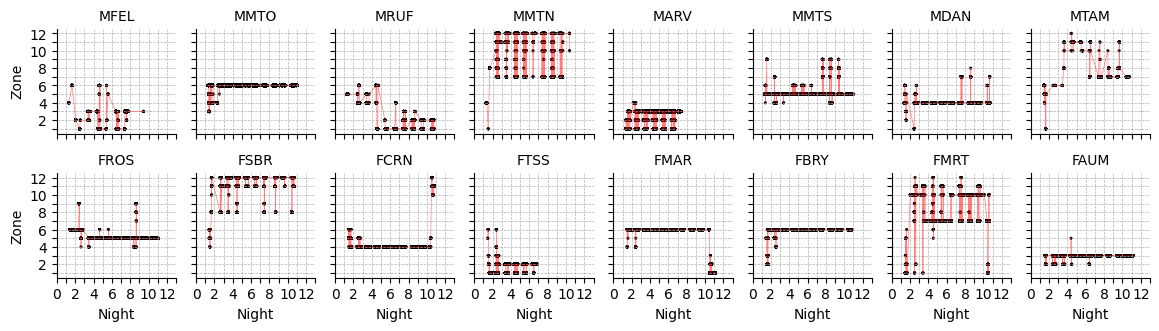

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter data for trial "T001"
filtered_data = data[data['trial'] == "T001"]

# Ensure that 'zone' is treated as a numeric variable
filtered_data['zone'] = pd.to_numeric(filtered_data['zone'])

# Create the facet grid
g = sns.FacetGrid(filtered_data, col="code", col_wrap=8, height=2.6, aspect=9/16)

# Plot the line plot
g.map_dataframe(sns.lineplot, x=filtered_data['noon_time_sec'] / 86400 + 1, y='zone', color="red", linewidth=0.5, alpha=0.5)

# Plot the scatter plot on top of the line plot
g.map_dataframe(sns.scatterplot, x=filtered_data['noon_time_sec'] / 86400 + 1, y='zone', color="black", s=5, edgecolor="none")

# Set ticks and labels
for ax in g.axes.flat:
    # Set major ticks for both axes (all ticks)
    ax.set_xticks(np.arange(0, 14, 1))  # Ensures 0 through 13 are tick positions
    ax.set_yticks(np.arange(1, 13, 1))  # 1 through 12 for y-axis
    
    # Label only even ticks and starting from 0 on the x-axis
    ax.set_xticklabels([label if label % 2 == 0 else '' for label in np.arange(0, 14, 1)])
    ax.set_yticklabels([label if label % 2 == 0 else '' for label in np.arange(1, 13, 1)])
    
    # Add gridlines for all ticks
    ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
    
    # Reverse the y-axis to show 12 at the top
    ax.invert_yaxis()

# Set common axis labels
g.set_axis_labels("Night", "Zone")

# Remove the "code =" prefix from the facet titles
g.set_titles(col_template="{col_name}")

# Show the plot
plt.show()


# Spatial RFID read heatmap visualization

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'df' is your DataFrame loaded from some source
# Let's recreate 'zone_coords' to store unique zone coordinates
zone_coords = data[['zone', 'zone_x', 'zone_y']].drop_duplicates()

# Group data and calculate reads, then expand it for all days and zones
df2 = data.groupby(['trial', 'genotype', 'sex', 'code', 'noon_day', 'zone']).size().reset_index(name='subject_zone_reads')

df2 = df2.groupby(['trial', 'genotype', 'sex', 'code'])\
         .apply(lambda x: x.set_index('noon_day').reindex(range(1, data['noon_day'].max()+1), fill_value=0))\
         .reset_index()

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:


# Ensure all zones are represented
all_zones = pd.DataFrame({'zone': range(1, 12)})
df2 = df2.merge(all_zones, on='zone', how='outer').fillna({'subject_zone_reads': 0})

# Join zone coordinates
df2 = df2.merge(zone_coords, on='zone', how='left')

# Calculate additional metrics
df2['subject_total_daily_sum'] = df2.groupby(['code', 'noon_day'])['subject_zone_reads'].transform('sum')
df2['subject_daily_zone_percent'] = 100 * df2['subject_zone_reads'] / df2['subject_total_daily_sum']

# Additional groupings and calculations for sex
df2['total_daily_zone_sex_reads'] = df2.groupby(['trial', 'sex', 'zone', 'noon_day'])['subject_zone_reads'].transform('sum')
df2['sex_competitor_percent'] = 100 * df2['subject_zone_reads'] / df2['total_daily_zone_sex_reads']
df2['sex_competitor_percent'] = df2['sex_competitor_percent'].fillna(0)
